In [379]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [380]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [381]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [382]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [383]:
train_delta_t = 0
max_depth = 3
eval_metric = 'rmse'
n_estimators = 10000
scaler_name = 'NormalizerMinMax'
scaler_a = StandardScaler()
scaler_b = Normalizer()
scaler_c = MinMaxScaler()
random_state = 42
submission_path = 'sub_4_inputs/'
test_set_param = 'rd_set' # 'basic'

In [384]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

In [385]:
# X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.get_reshaped_files3()

In [386]:
def clean_reshaped_data(df: pd.DataFrame, time_column = 'date_forecast'):
    df_cleaned = df.copy()
    mask_45 = df_cleaned[time_column].dt.strftime('%M:%S') == '45:00'
    mask_30 = df_cleaned[time_column].dt.strftime('%M:%S') == '30:00'
    mask_15 = df_cleaned[time_column].dt.strftime('%M:%S') == '15:00'
    mask_0 = df_cleaned[time_column].dt.strftime('%M:%S') == '0:00'

    df_cleaned.loc[mask_45, time_column] = df_cleaned.loc[mask_45, time_column] + pd.Timedelta(minutes=15)
    df_cleaned.loc[mask_30, time_column] = df_cleaned.loc[mask_30, time_column] + pd.Timedelta(minutes=30)
    df_cleaned.loc[mask_15, time_column] = df_cleaned.loc[mask_15, time_column] + pd.Timedelta(minutes=45)

    df_cleaned['0_min_before'] = 0
    df_cleaned['15_min_before'] = 0
    df_cleaned['30_min_before'] = 0
    df_cleaned['45_min_before'] = 0

    df_cleaned.loc[mask_0, '0_min_before'] = 1
    df_cleaned.loc[mask_45, '15_min_before'] = 1
    df_cleaned.loc[mask_30, '30_min_before'] = 1
    df_cleaned.loc[mask_15, '45_min_before'] = 1

    return df_cleaned

In [387]:
X_train_estimated_a = clean_reshaped_data(X_train_estimated_a)
X_train_estimated_b = clean_reshaped_data(X_train_estimated_b)
X_train_estimated_c = clean_reshaped_data(X_train_estimated_c)
X_train_observed_a = clean_reshaped_data(X_train_observed_a)
X_train_observed_b = clean_reshaped_data(X_train_observed_b)
X_train_observed_c = clean_reshaped_data(X_train_observed_c)
X_test_estimated_a = clean_reshaped_data(X_test_estimated_a)
X_test_estimated_b = clean_reshaped_data(X_test_estimated_b)
X_test_estimated_c = clean_reshaped_data(X_test_estimated_c)

In [388]:
# X_train_estimated_b['date_forecast'] = X_train_estimated_b['date_forecast']+ pd.Timedelta(minutes=15)

# B and C clean up

In [389]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [390]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [391]:
delta = { 'hours': 12 * 5 }
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [392]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [393]:
X_train_estimated_a = X_train_estimated_a.drop(columns='date_calc')
X_train_estimated_b = X_train_estimated_b.drop(columns='date_calc')
X_train_estimated_c = X_train_estimated_c.drop(columns='date_calc')

In [394]:
len(X_train_observed_a), len(X_train_estimated_a)

(118669, 17576)

In [395]:
len(X_train_observed_b), len(X_train_estimated_b)

(116929, 17576)

In [396]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [397]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [398]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [399]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [400]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [401]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [402]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [403]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [404]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [405]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [406]:
start_2019 = pd.to_datetime("2019-04-21")
end_2019 = pd.to_datetime("2019-07-22")

start_2020 = pd.to_datetime("2020-04-21")
end_2020 = pd.to_datetime("2020-07-22")

start_2021 = pd.to_datetime("2021-04-21")
end_2021 = pd.to_datetime("2021-07-22")

start_2022 = pd.to_datetime("2022-04-21")
end_2022 = pd.to_datetime("2022-07-22")

In [407]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [408]:
def split_training_testing_set_on_test_set_dates():
    quantile = .25
    pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= X_train_estimated_a['date_forecast'].quantile(quantile)].copy()
    pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > X_train_estimated_a['date_forecast'].quantile(quantile)].copy()

    pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= X_train_estimated_b['date_forecast'].quantile(quantile)].copy()
    pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > X_train_estimated_b['date_forecast'].quantile(quantile)].copy()

    pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= X_train_estimated_c['date_forecast'].quantile(quantile)].copy()
    pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > X_train_estimated_c['date_forecast'].quantile(quantile)].copy() 
    return pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c

In [409]:
def split_training_testing_set(df, start_estimated, random_state=42, test_size = .15, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022]
    df_estimated = df_to_split[mask_estimated]
    print(len(df_estimated))
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]

    # test_size_summer = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))
    # test_size_estimated = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))

    test_size_estimated = 0.8
    test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
    # test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
    # test_size_estimated = 1 - test_size_summer
    # train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    unique_dates_summer = df_summers[time_column].dt.date.unique()
    unique_dates_estimated = df_summers[time_column].dt.date.unique()

    train_dates_summer, test_dates_summer = train_test_split(unique_dates_summer, test_size=test_size_summer, random_state=random_state)
    train_dates_estimated, test_dates_estimated = train_test_split(unique_dates_estimated, test_size=test_size_estimated, random_state=random_state)

    train_data_summer = df_summers[df_summers[time_column].dt.date.isin(train_dates_summer)]
    train_data_estimated = df_estimated[df_estimated[time_column].dt.date.isin(train_dates_estimated)]

    pv_test_summer_not_ordered = df_summers[df_summers[time_column].dt.date.isin(test_dates_summer)]
    pv_test_estimated_not_ordered = df_estimated[df_estimated[time_column].dt.date.isin(test_dates_estimated)]

    pv_test_not_ordered = pd.concat([pv_test_summer_not_ordered, pv_test_estimated_not_ordered])
    pv_train_not_ordered = pd.concat([train_data_summer, train_data_estimated, df_not_summer])

    pv_train = pv_train_not_ordered.sort_values(by=time_column)
    pv_test = pv_test_not_ordered.sort_values(by=time_column)
    return pv_train, pv_test

In [410]:
def split_training_testing_set(df, start_estimated, random_state=42, test_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]
    test_size = test_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by='date_forecast')
    pv_test = pv_test_not_ordered.sort_values(by='date_forecast')
    return pv_train, pv_test

In [411]:
# create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast')
df_to_split = X_total_b_y_nan
start_estimated = X_train_estimated_b["date_forecast"].mean()
mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

In [412]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [413]:
if test_set_param=='basic': pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c = split_training_testing_set_on_test_set_dates()

In [414]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100, '%')
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100, '%')
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100, '%')

train_a : (122559, 50)
test_a : (13618, 50)
Rapport test/total : 10.0 %
train_b : (97781, 50)
test_b : (10865, 50)
Rapport test/total : 10.0 %
train_c : (78124, 50)
test_c : (8681, 50)
Rapport test/total : 10.0 %


## Changement type de la date_forecast

In [415]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [416]:
#function to apply XGBoost model
def create_features(df, label):
    df_cleaned = df.copy()
    mask_45 = df_cleaned["date_forecast"].dt.strftime('%M:%S') == '45:00'
    mask_30 = df_cleaned["date_forecast"].dt.strftime('%M:%S') == '30:00'
    mask_15 = df_cleaned["date_forecast"].dt.strftime('%M:%S') == '15:00'
    mask_0 = df_cleaned["date_forecast"].dt.strftime('%M:%S') == '0:00'

    df_cleaned['0_min_before'] = 0
    df_cleaned['15_min_before'] = 0
    df_cleaned['30_min_before'] = 0
    df_cleaned['45_min_before'] = 0

    df_cleaned.loc[mask_0, '0_min_before'] = 1
    df_cleaned.loc[mask_45, '15_min_before'] = 1
    df_cleaned.loc[mask_30, '30_min_before'] = 1
    df_cleaned.loc[mask_15, '45_min_before'] = 1
    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) if "date_calc" in df.columns else df.drop(["date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [417]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [418]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None,fit=True):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : 
      if fit:
        normalized_data = scaler.fit_transform(df)
      else: 
        normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [419]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [420]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a, fit=False)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b, fit=False)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c, fit=False)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [421]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [422]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:877.97312	validation_1-rmse:1183.05005
[1]	validation_0-rmse:723.77065	validation_1-rmse:971.77025
[2]	validation_0-rmse:623.45543	validation_1-rmse:836.65503
[3]	validation_0-rmse:564.36906	validation_1-rmse:749.11111
[4]	validation_0-rmse:530.16184	validation_1-rmse:699.97160
[5]	validation_0-rmse:508.77641	validation_1-rmse:669.84352
[6]	validation_0-rmse:492.55013	validation_1-rmse:652.03147
[7]	validation_0-rmse:482.64515	validation_1-rmse:640.22144
[8]	validation_0-rmse:477.26071	validation_1-rmse:631.61492
[9]	validation_0-rmse:473.03516	validation_1-rmse:626.50016
[10]	validation_0-rmse:469.57363	validation_1-rmse:622.40059
[11]	validation_0-rmse:466.09935	validation_1-rmse:619.07447


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:463.79484	validation_1-rmse:612.96514
[13]	validation_0-rmse:461.59313	validation_1-rmse:609.96611
[14]	validation_0-rmse:458.12597	validation_1-rmse:605.33948
[15]	validation_0-rmse:456.40887	validation_1-rmse:604.04859
[16]	validation_0-rmse:454.81803	validation_1-rmse:601.29154
[17]	validation_0-rmse:453.19689	validation_1-rmse:600.42614
[18]	validation_0-rmse:451.36401	validation_1-rmse:598.73680
[19]	validation_0-rmse:449.98048	validation_1-rmse:596.25913
[20]	validation_0-rmse:448.31530	validation_1-rmse:593.81875
[21]	validation_0-rmse:446.79828	validation_1-rmse:592.42603
[22]	validation_0-rmse:445.50289	validation_1-rmse:589.87338
[23]	validation_0-rmse:444.40670	validation_1-rmse:588.72325
[24]	validation_0-rmse:443.10187	validation_1-rmse:587.75747
[25]	validation_0-rmse:442.34612	validation_1-rmse:587.04381
[26]	validation_0-rmse:441.10629	validation_1-rmse:585.16416
[27]	validation_0-rmse:440.37107	validation_1-rmse:584.36056
[28]	validation_0-rmse:4

[71]	validation_0-rmse:413.36318	validation_1-rmse:555.56906
[72]	validation_0-rmse:412.77454	validation_1-rmse:555.20713
[73]	validation_0-rmse:412.45956	validation_1-rmse:554.99413
[74]	validation_0-rmse:412.20181	validation_1-rmse:554.81799
[75]	validation_0-rmse:411.82710	validation_1-rmse:554.82443
[76]	validation_0-rmse:411.48041	validation_1-rmse:554.47034
[77]	validation_0-rmse:411.28913	validation_1-rmse:554.33985
[78]	validation_0-rmse:410.79399	validation_1-rmse:553.26603
[79]	validation_0-rmse:410.44989	validation_1-rmse:552.93304
[80]	validation_0-rmse:410.11918	validation_1-rmse:552.93793
[81]	validation_0-rmse:409.83995	validation_1-rmse:552.64710
[82]	validation_0-rmse:409.50664	validation_1-rmse:552.53960
[83]	validation_0-rmse:408.92753	validation_1-rmse:551.86018
[84]	validation_0-rmse:408.62155	validation_1-rmse:551.47410
[85]	validation_0-rmse:408.38555	validation_1-rmse:551.47610
[86]	validation_0-rmse:408.24658	validation_1-rmse:550.57142
[87]	validation_0-rmse:4

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:72.28069	validation_1-rmse:112.73746
[15]	validation_0-rmse:72.03833	validation_1-rmse:112.46033
[16]	validation_0-rmse:71.73609	validation_1-rmse:112.38806
[17]	validation_0-rmse:71.47595	validation_1-rmse:112.27537
[18]	validation_0-rmse:71.23959	validation_1-rmse:111.92828
[19]	validation_0-rmse:70.92519	validation_1-rmse:111.70079
[20]	validation_0-rmse:70.73229	validation_1-rmse:111.52683
[21]	validation_0-rmse:70.61002	validation_1-rmse:111.34271
[22]	validation_0-rmse:70.43983	validation_1-rmse:111.28752
[23]	validation_0-rmse:70.27137	validation_1-rmse:111.08282
[24]	validation_0-rmse:70.09006	validation_1-rmse:110.79504
[25]	validation_0-rmse:69.86113	validation_1-rmse:110.45166
[26]	validation_0-rmse:69.68445	validation_1-rmse:110.29664
[27]	validation_0-rmse:69.54306	validation_1-rmse:110.15602
[28]	validation_0-rmse:69.44832	validation_1-rmse:110.00292
[29]	validation_0-rmse:69.20684	validation_1-rmse:109.84296
[30]	validation_0-rmse:69.05485	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:55.21349	validation_1-rmse:85.87997
[33]	validation_0-rmse:55.05331	validation_1-rmse:85.74144
[34]	validation_0-rmse:54.87749	validation_1-rmse:85.45728
[35]	validation_0-rmse:54.81540	validation_1-rmse:85.35968
[36]	validation_0-rmse:54.72866	validation_1-rmse:85.24663
[37]	validation_0-rmse:54.64599	validation_1-rmse:85.19512
[38]	validation_0-rmse:54.53053	validation_1-rmse:85.13170
[39]	validation_0-rmse:54.38107	validation_1-rmse:84.94100
[40]	validation_0-rmse:54.23954	validation_1-rmse:84.78962
[41]	validation_0-rmse:54.10360	validation_1-rmse:84.66146
[42]	validation_0-rmse:53.90318	validation_1-rmse:84.44561
[43]	validation_0-rmse:53.84827	validation_1-rmse:84.45423
[44]	validation_0-rmse:53.71869	validation_1-rmse:84.08381
[45]	validation_0-rmse:53.59492	validation_1-rmse:83.96156
[46]	validation_0-rmse:53.48446	validation_1-rmse:83.93381
[47]	validation_0-rmse:53.31101	validation_1-rmse:83.76858
[48]	validation_0-rmse:53.26007	validation_1-rmse:83.742

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

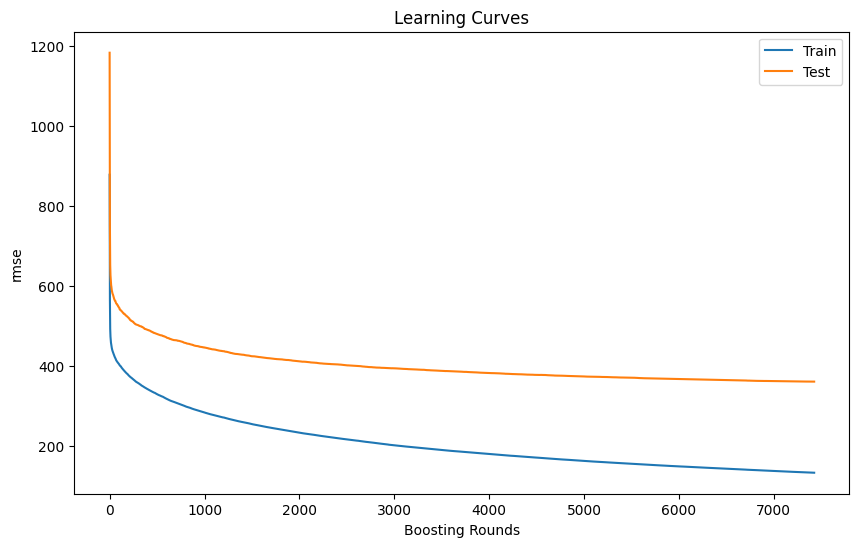

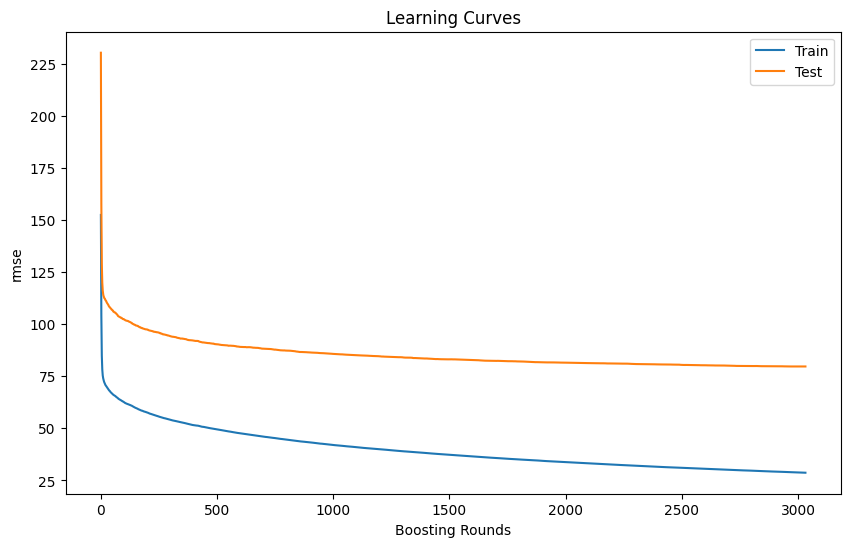

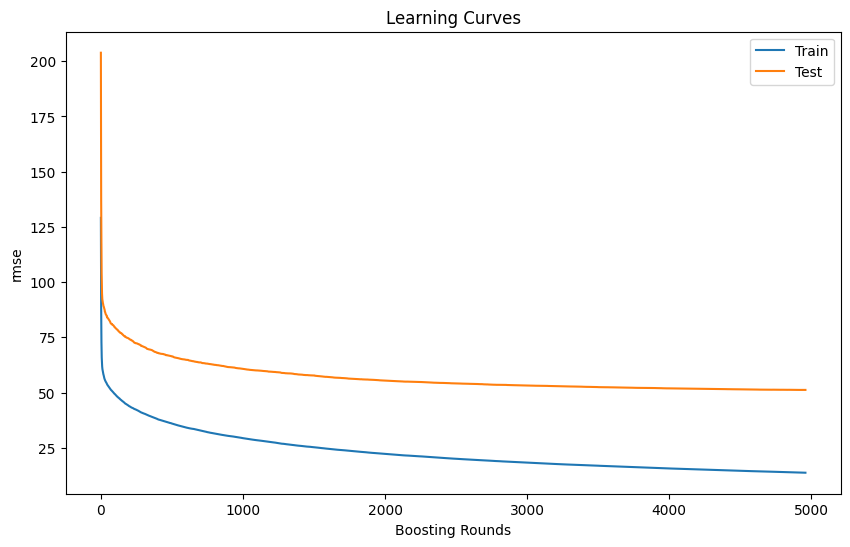

In [423]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [424]:
min_error_a, min_error_b, min_error_c

(360.53518115245697, 79.69618158587019, 51.202336040591334)

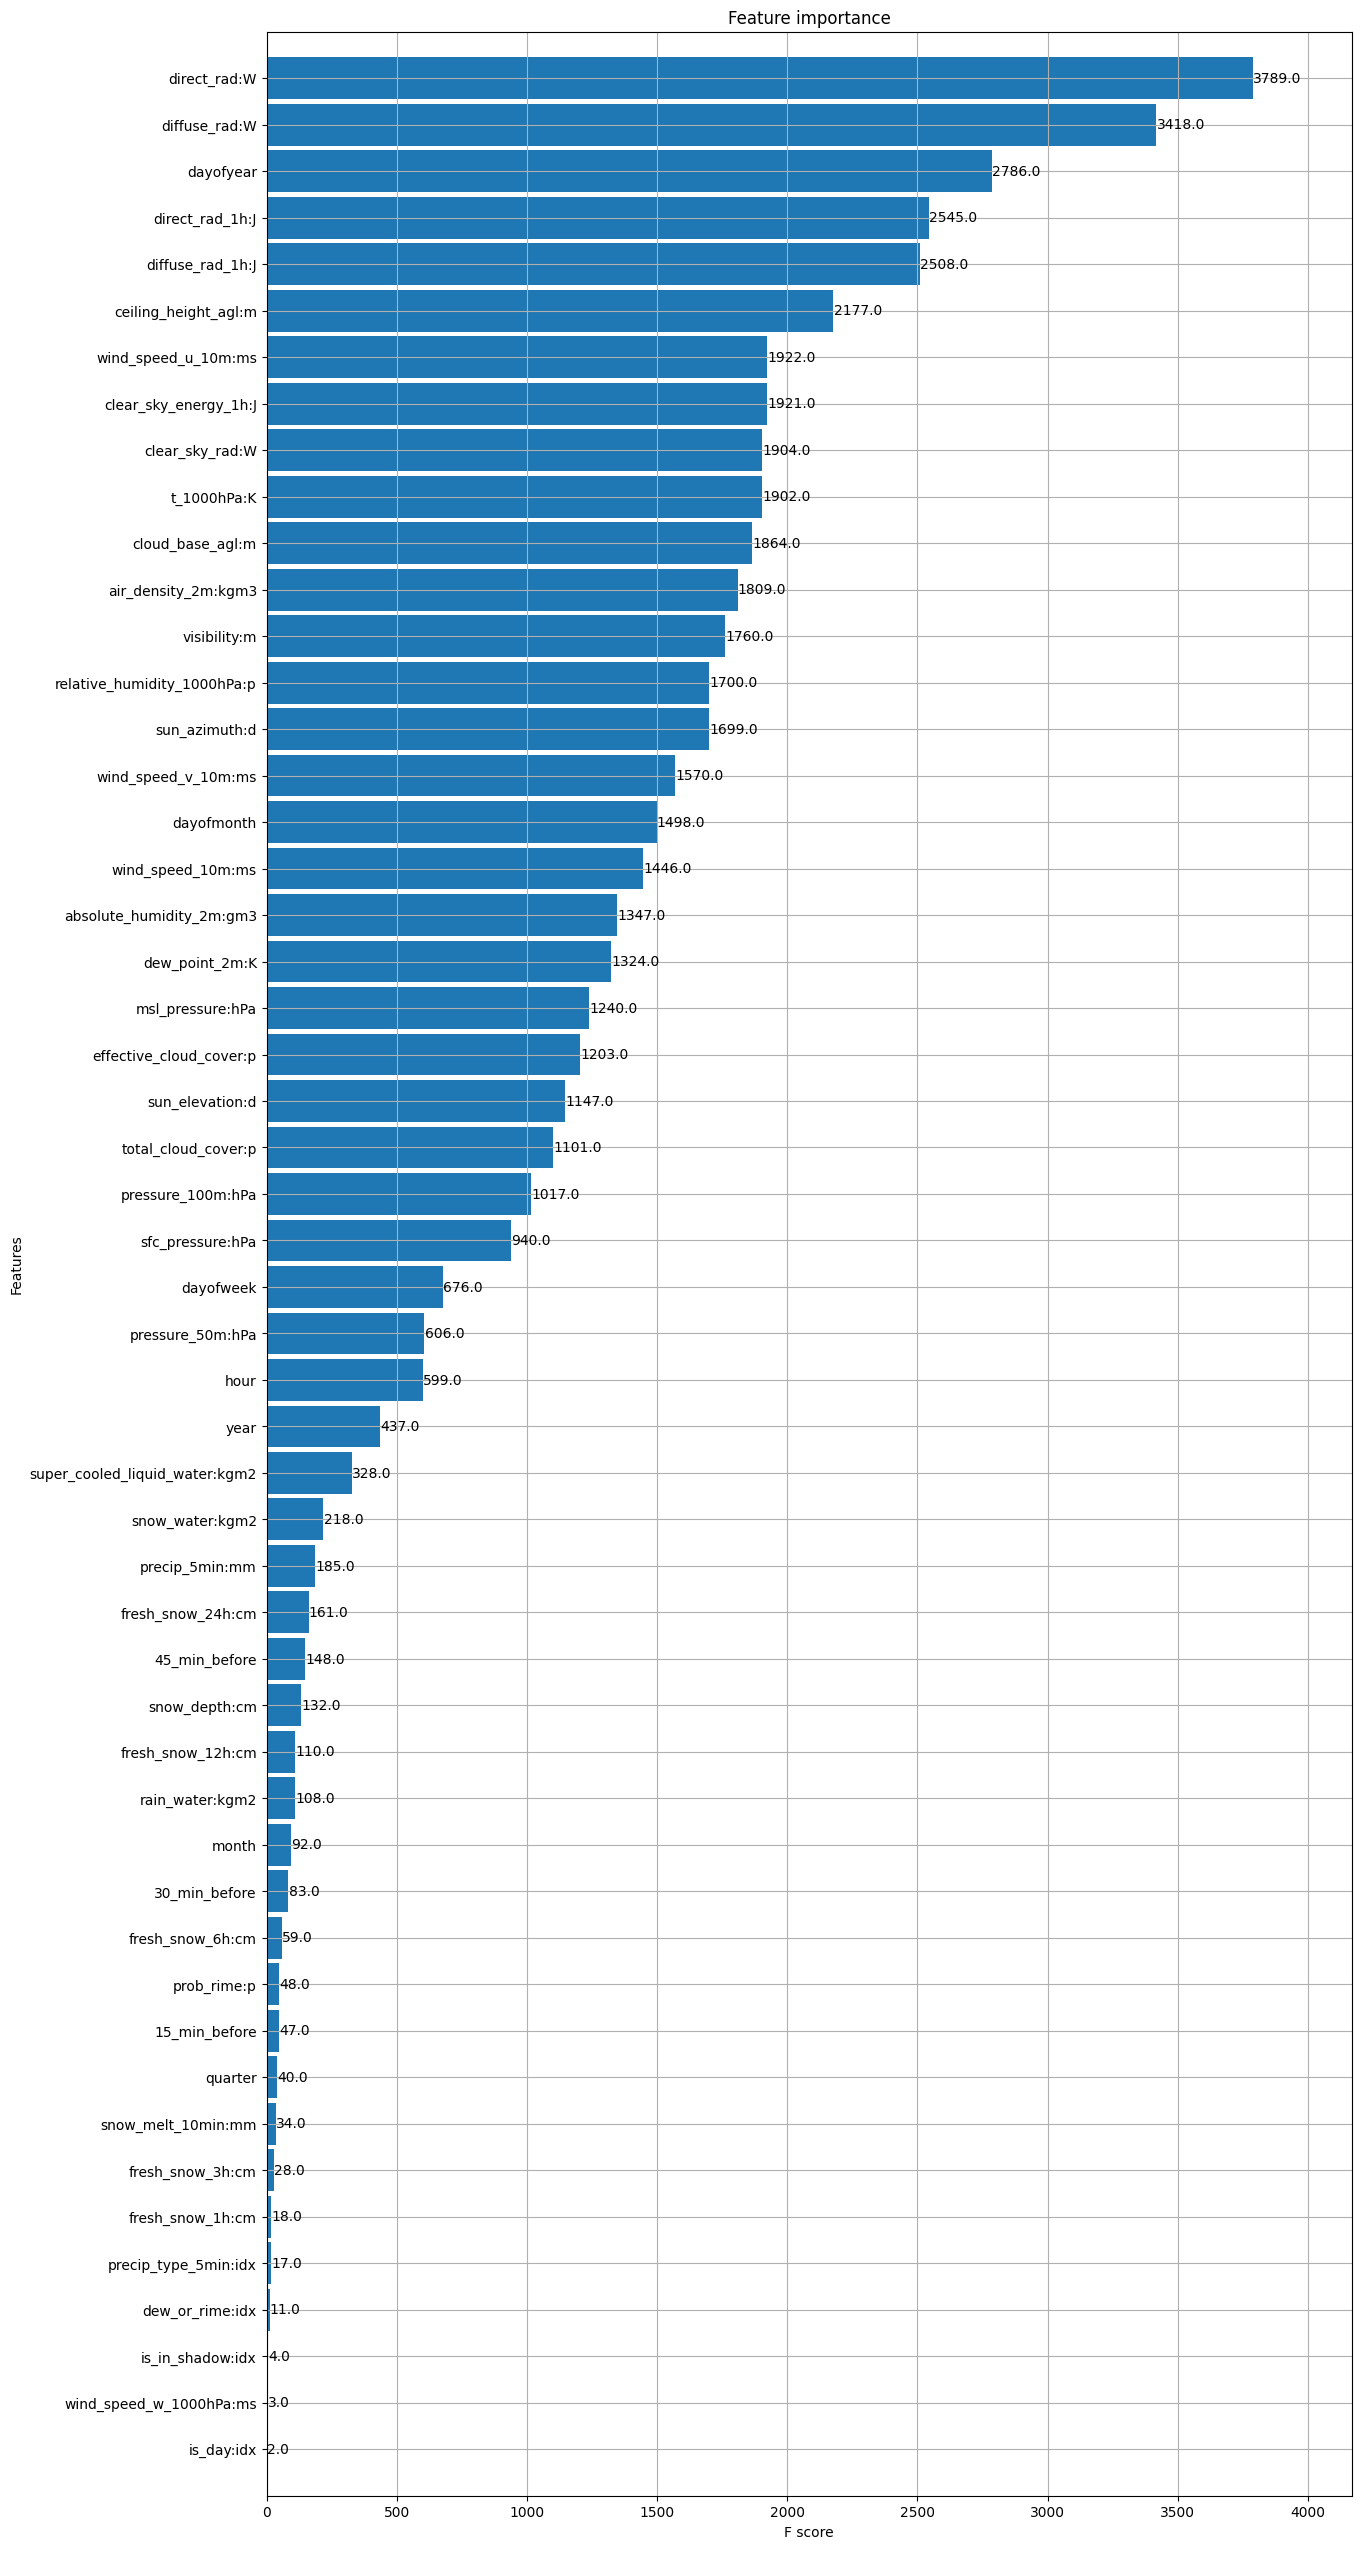

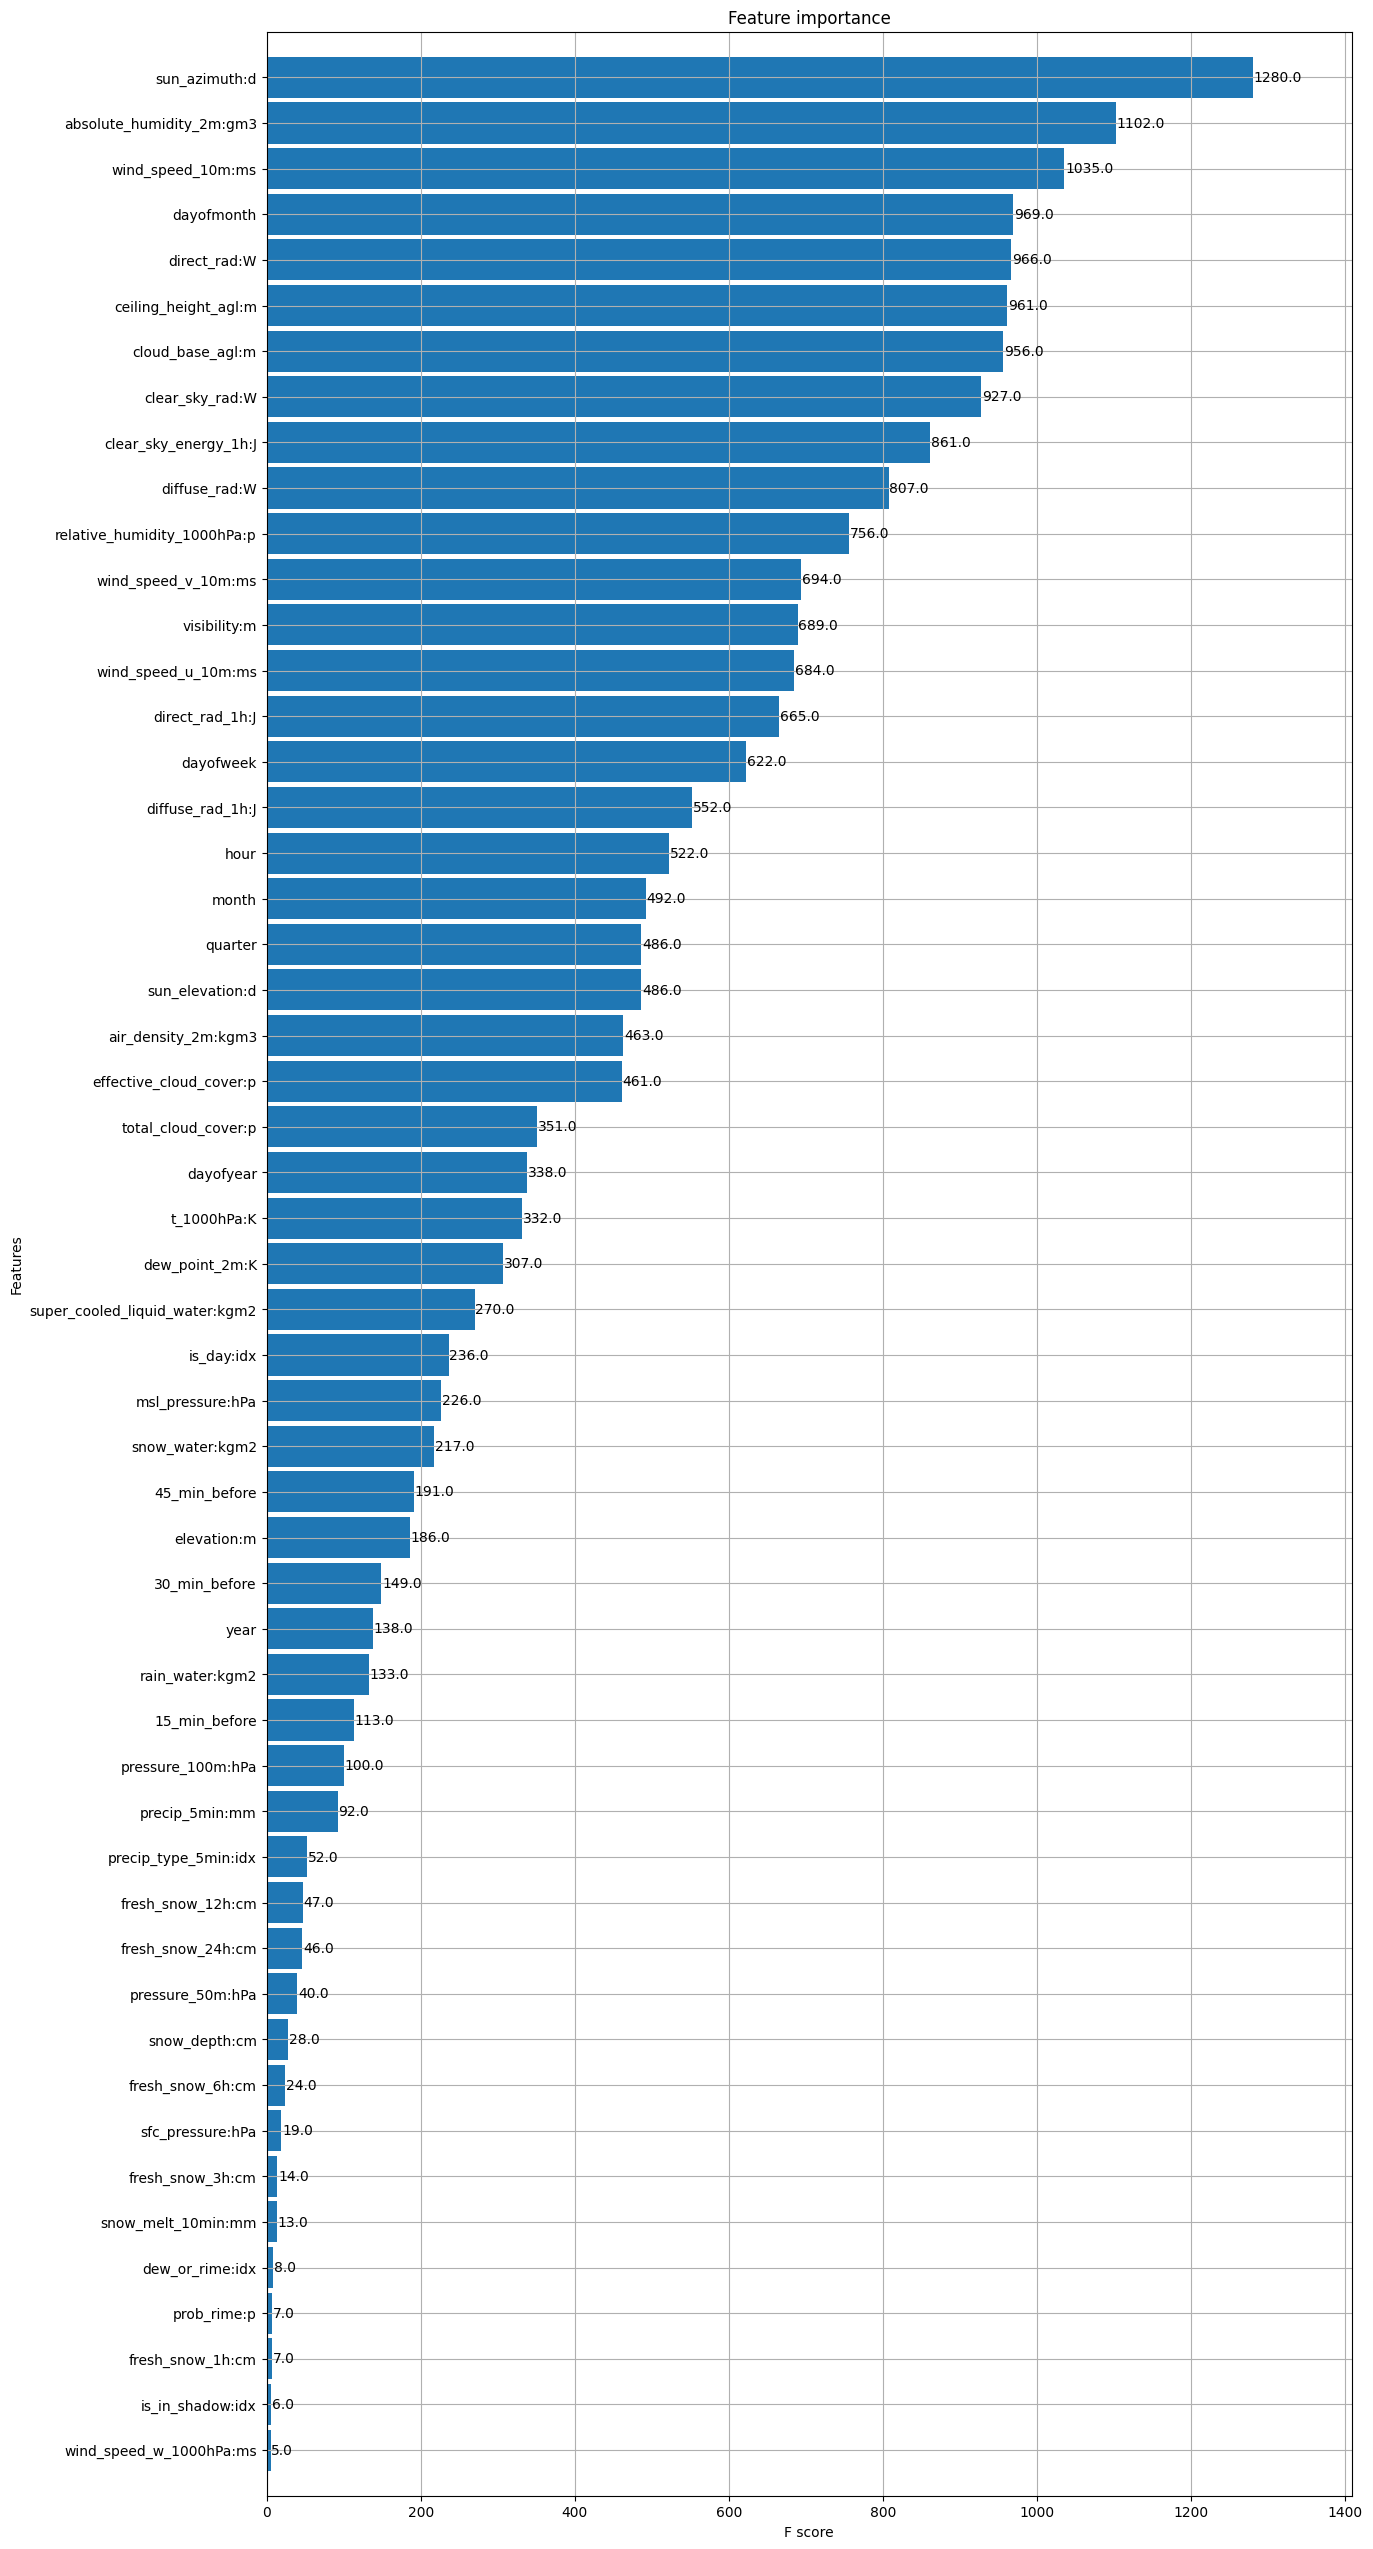

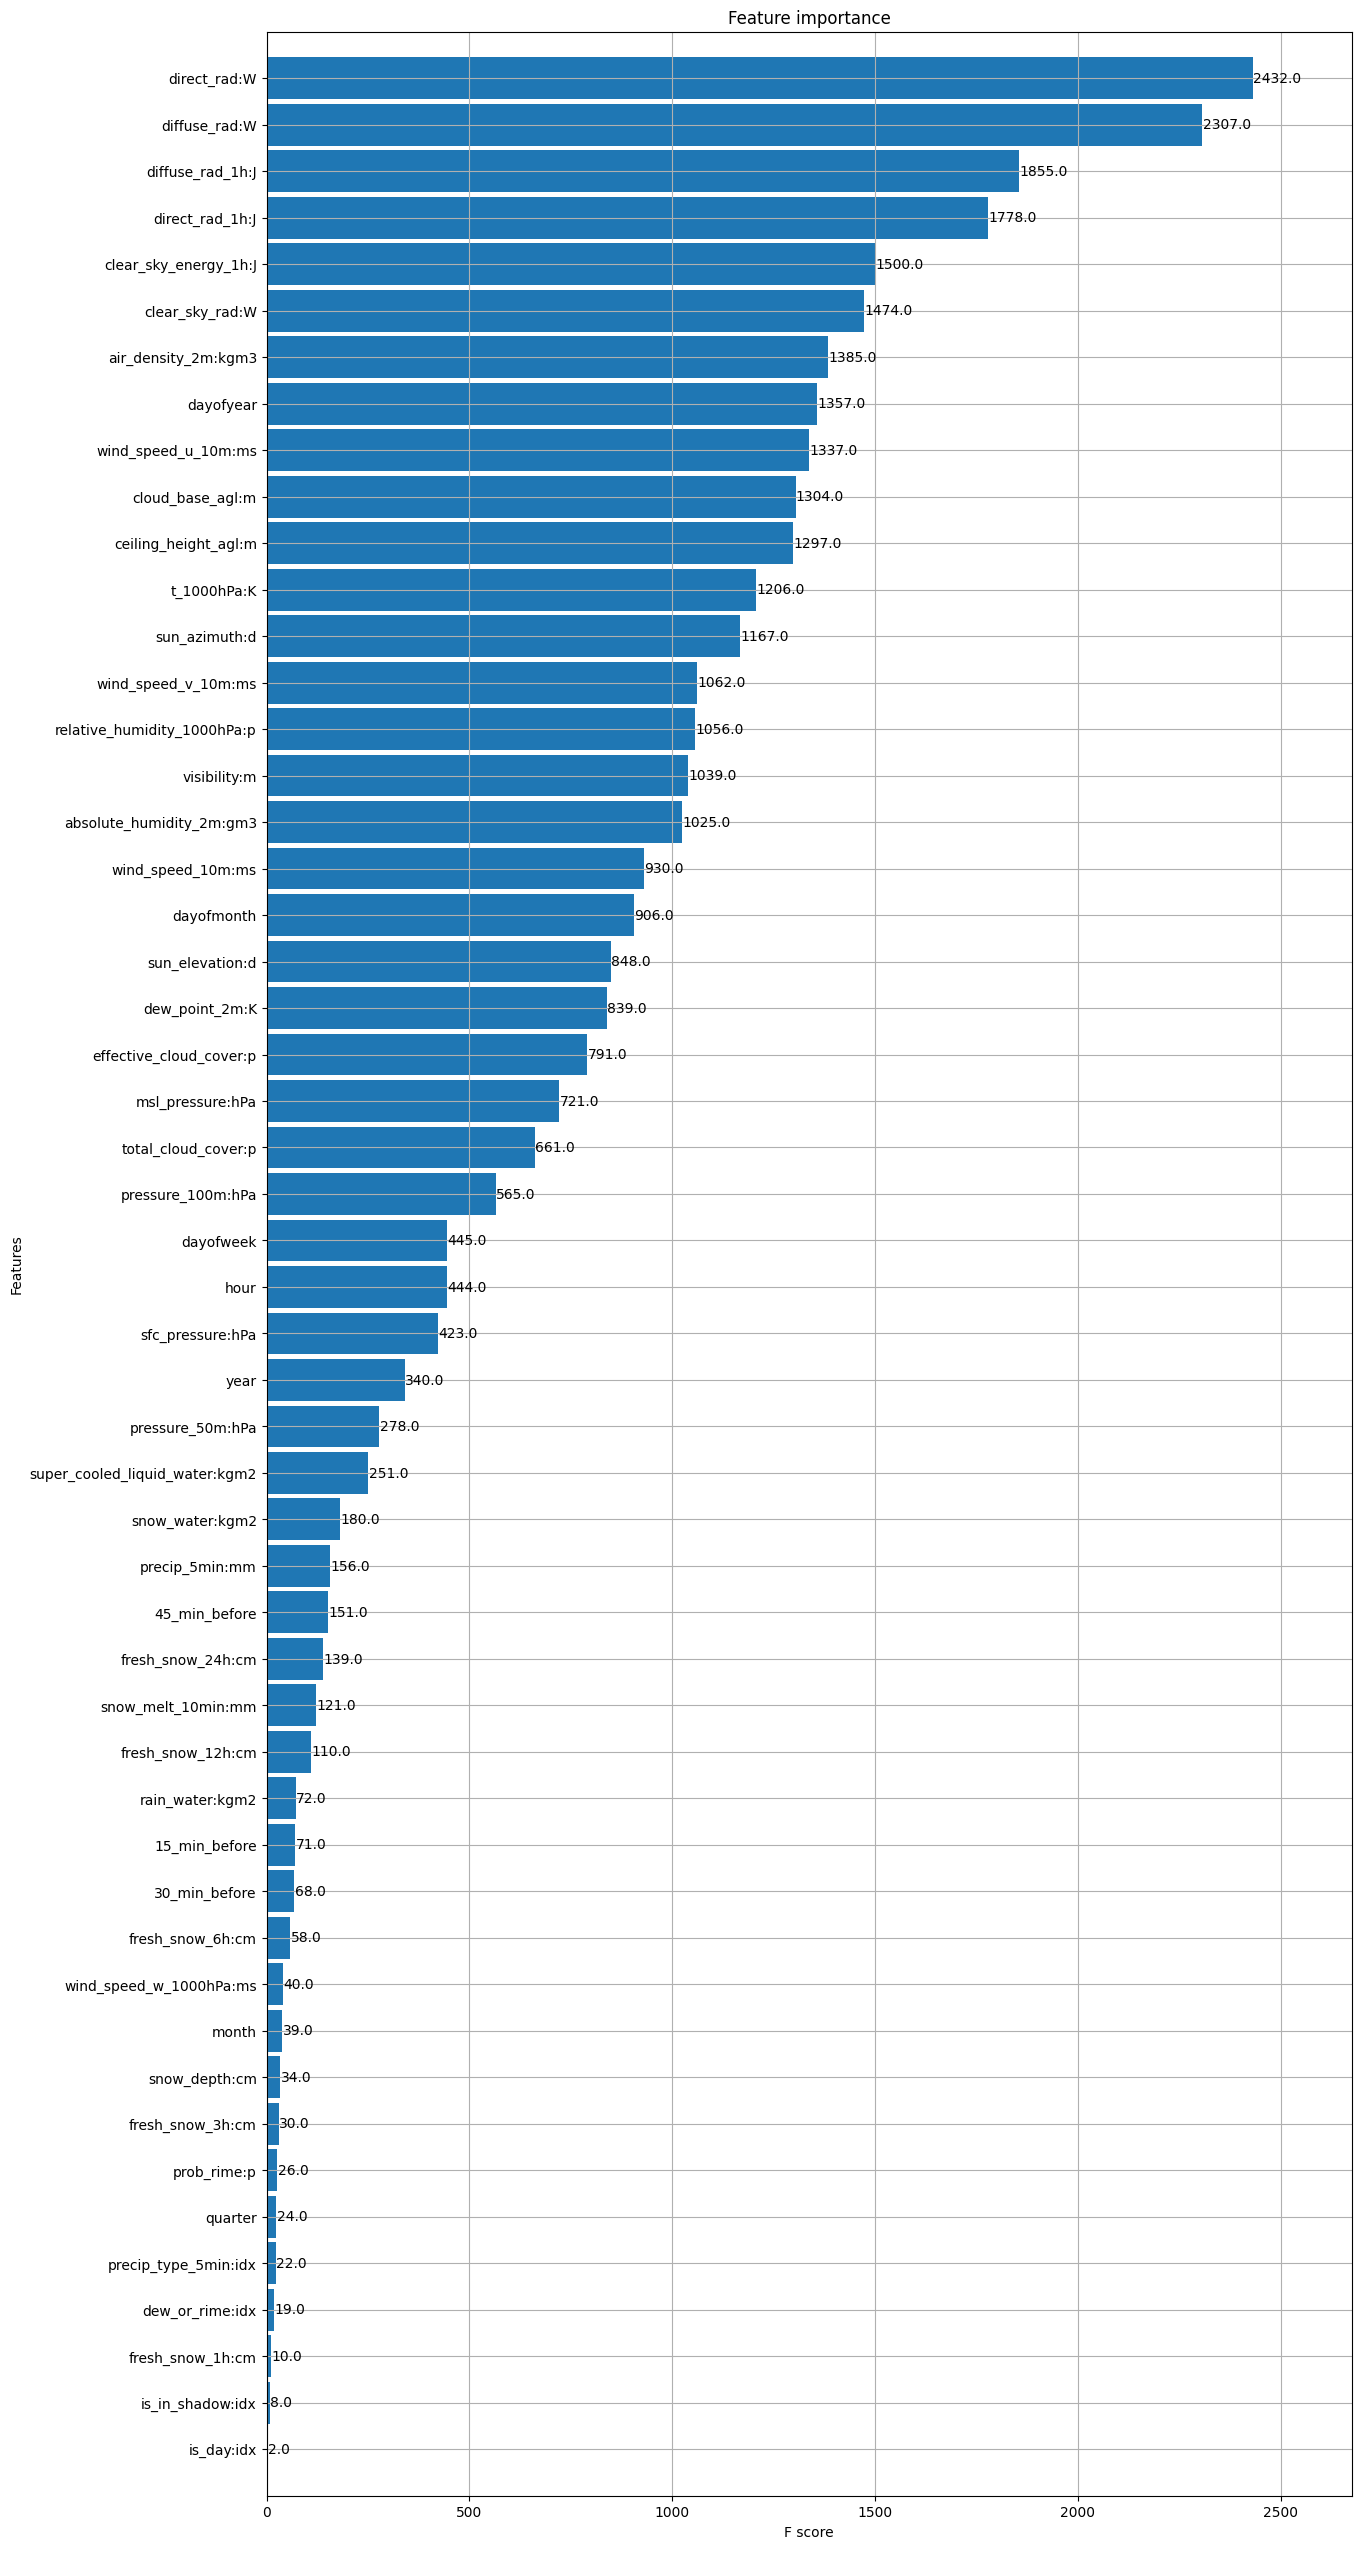

In [425]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8 * 4)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8 * 4)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8 * 4)

In [426]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [427]:
# XGBoost_separated_loc_4_inputs_n_estimators_10000_delta_0_min_StandardScaler_rmse_max_depth_3_mae_123_rmse_367_60_57_rd_subsets_42_by_day.csv



In [428]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_72947/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_72947/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_72947/182118369.py:

In [429]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

df_mae = pd.concat([pv_all_a, pv_all_b, pv_all_a])
mae = np.mean(np.abs(df_mae['pv_measurement'] - df_mae['pv_measurement_prediction']))
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 212.64572883191929 MAE b: 45.79944686694485 MAE c: 276.01801832210276
MAE on test set: 165.06732266017977


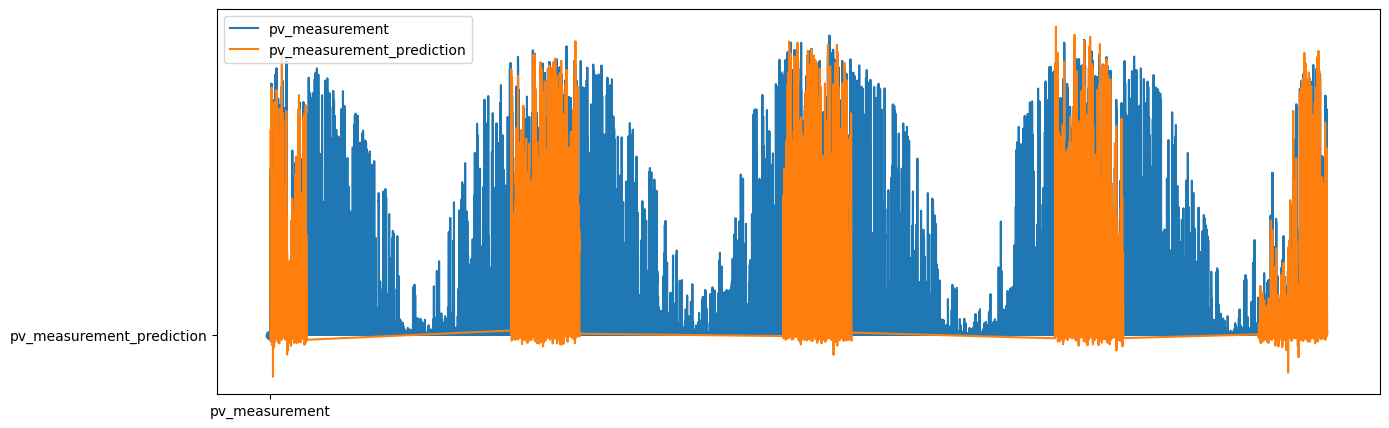

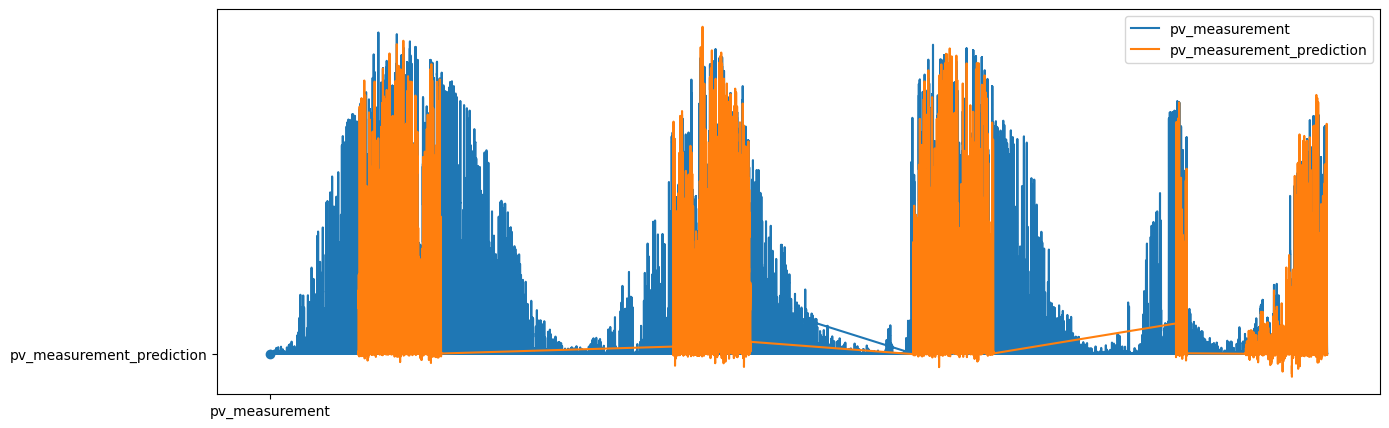

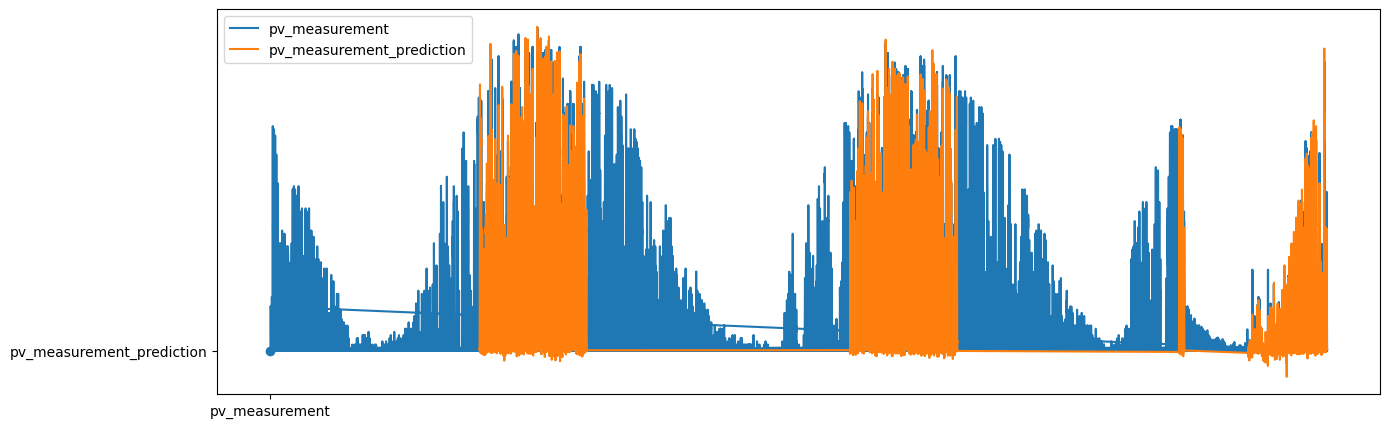

In [430]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

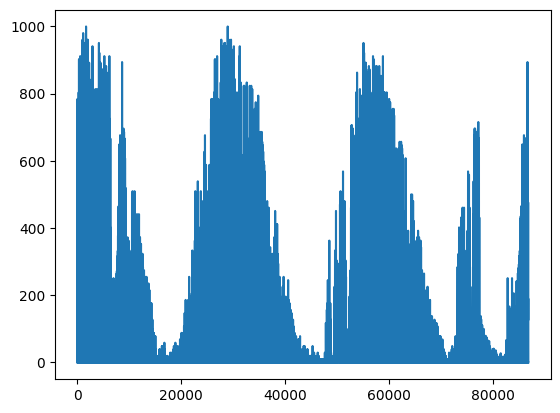

In [431]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [432]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [433]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [434]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler, fit=False)
  return X_test

In [435]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [451]:
result_A = reg_a.predict(X_test_a_test[X_test_a_test['0_min_before'] != 0])
result_B = reg_b.predict(X_test_b_test[X_test_b_test['0_min_before'] != 0])
result_C = reg_c.predict(X_test_c_test[X_test_c_test['0_min_before'] != 0])

In [453]:
X_test_a_test[X_test_a_test['0_min_before'] != 0]

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,0_min_before,15_min_before,30_min_before,45_min_before,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth


In [450]:
X_test_a_test

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,0_min_before,15_min_before,30_min_before,45_min_before,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,-0.654312,0.844796,-0.857229,-0.620048,-0.618551,-0.418786,-0.10873,-0.582571,-0.639269,-0.64742,-0.434702,-0.441174,0.380574,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,0.362314,-0.16869,-0.23228,0.342572,0.354513,-0.081371,-0.236456,0.437942,0.364171,-0.161436,0.0,-0.047885,-0.372542,-1.644293,-0.397749,-0.520626,-0.887372,0.186189,-0.144251,0.514633,0.542216,1.489093,-0.011064,0.0,-0.578321,-0.576750,-0.576449,-1.660981,-1.498135,-0.486736,-0.470095,1.857802,-0.611739,-1.671724
1,-0.690140,0.871591,-0.857229,-0.620048,-0.618551,-0.411845,-0.10873,-0.582571,-0.639269,-0.64742,-0.434702,-0.441174,0.271853,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,0.346861,-0.16869,-0.23228,0.334758,0.346740,-0.081371,-0.236456,0.437942,0.356435,-0.161436,0.0,-0.047885,-0.372542,-1.608461,-0.382709,-0.520626,-0.887372,0.076748,-0.155806,0.514633,0.507830,1.489093,-0.011064,0.0,-0.578321,-0.576750,1.734759,-1.516468,-1.498135,-0.486736,-0.470095,1.857802,-0.611739,-1.671724
2,-0.690140,0.871591,-0.857229,-0.620048,-0.618551,-0.404955,-0.10873,-0.597045,-0.639269,-0.64742,-0.434702,-0.441174,0.157255,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,0.339132,-0.16869,-0.23228,0.326949,0.331189,-0.081371,-0.236456,0.437942,0.340958,-0.161436,0.0,-0.047885,-0.372542,-1.572794,-0.363282,-0.520626,-0.887372,-0.038608,-0.167327,0.458868,0.507830,1.435042,-0.011064,0.0,-0.578321,1.733852,-0.576449,-1.516468,-1.498135,-0.486736,-0.470095,1.857802,-0.611739,-1.671724
3,-0.690140,0.871591,-0.857229,-0.620048,-0.618551,-0.398013,-0.10873,-0.597045,-0.639269,-0.64742,-0.434702,-0.441174,0.036781,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,0.331407,-0.16869,-0.23228,0.319140,0.323411,-0.081371,-0.236456,0.430654,0.333222,-0.161436,0.0,-0.047885,-0.372542,-1.537332,-0.339636,-0.520626,-0.887372,-0.159880,-0.177286,0.458868,0.473444,1.435042,-0.011064,0.0,1.729144,-0.576750,-0.576449,-1.516468,-1.498135,-0.486736,-0.470095,1.857802,-0.611739,-1.671724
4,-0.690140,0.871591,-0.753369,-0.620048,-0.618551,-0.391123,-0.10873,-0.597045,-0.639269,-0.64742,-0.434702,-0.441174,-0.095447,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,0.315953,-0.16869,-0.23228,0.303517,0.315638,-0.081371,-0.236456,0.430654,0.325482,-0.161436,0.0,-0.047885,-0.372542,-1.502103,-0.311812,-0.520626,-0.887372,-0.292984,-0.183484,0.458868,0.473444,1.435042,-0.011064,0.0,-0.578321,-0.576750,-0.576449,-1.516468,-1.498135,-0.486736,-0.470095,1.857802,-0.611739,-1.671724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,0.993748,-1.272190,-0.345663,-0.618264,-0.618551,0.022453,-0.10873,0.995048,-0.639269,-0.60335,-0.434702,-0.441174,0.862471,0.0,-0.147841,-0.082148,-0.1877,-0.101977,-0.119627,-0.953409,0.886376,-1.244771,-0.16869,-0.23228,-1.227438,-1.239341,-0.081371,-0.236456,0.510824,-1.253030,-0.161436,0.0,-0.047885,-0

In [448]:
result_A

array([], shape=(0, 0), dtype=float32)

In [447]:
len(result_A) + len(result_B) + len(result_C)

0

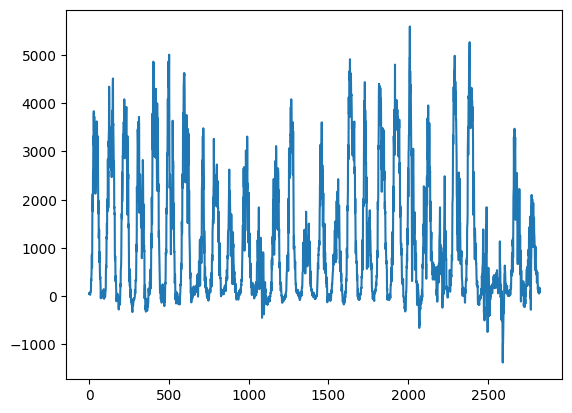

In [438]:
plt.plot(result_A)

In [439]:
# nom_fichier = 'XGBoost_Valentin_V2'
# repertoire = path
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
# test_copy['prediction'] = result
# sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
# sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [440]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

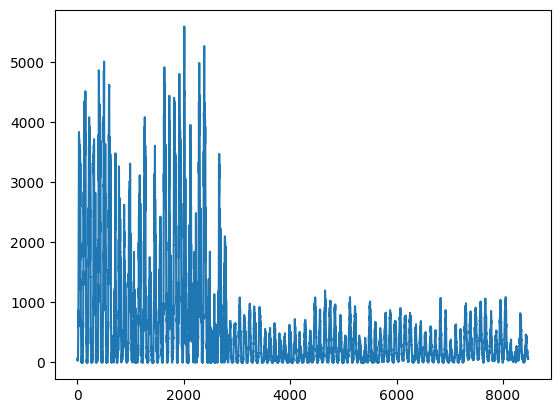

In [455]:
plt.plot(result)

In [458]:
X_train_estimated_a.loc[np.argmax(np.array(result))]

date_forecast                     2022-11-18 21:00:00
absolute_humidity_2m:gm3                          3.5
air_density_2m:kgm3                             1.305
ceiling_height_agl:m                              NaN
clear_sky_energy_1h:J                             0.0
clear_sky_rad:W                                   0.0
cloud_base_agl:m                                  NaN
dew_or_rime:idx                                   0.0
dew_point_2m:K                             268.700012
diffuse_rad:W                                     0.0
diffuse_rad_1h:J                                  0.0
direct_rad:W                                      0.0
direct_rad_1h:J                                   0.0
effective_cloud_cover:p                           0.0
elevation:m                                       6.0
fresh_snow_12h:cm                                 0.0
fresh_snow_1h:cm                                  0.0
fresh_snow_24h:cm                                 0.0
fresh_snow_3h:cm            

In [457]:
X_test_a_test.loc[np.argmax(np.array(result))]

absolute_humidity_2m:gm3          1.961088
air_density_2m:kgm3              -1.727743
ceiling_height_agl:m              2.354548
clear_sky_energy_1h:J             2.147882
clear_sky_rad:W                   2.381073
cloud_base_agl:m                  3.862739
dew_or_rime:idx                  -0.108730
dew_point_2m:K                    1.646359
diffuse_rad:W                     0.765512
diffuse_rad_1h:J                  0.758376
direct_rad:W                      4.318370
direct_rad_1h:J                   3.935111
effective_cloud_cover:p          -1.376590
elevation:m                       0.000000
fresh_snow_12h:cm                -0.147841
fresh_snow_1h:cm                 -0.082148
fresh_snow_24h:cm                -0.187700
fresh_snow_3h:cm                 -0.101977
fresh_snow_6h:cm                 -0.119627
is_day:idx                        1.048868
is_in_shadow:idx                 -1.128189
msl_pressure:hPa                  0.570922
precip_5min:mm                   -0.168690
precip_type

In [441]:
len(result_A), len(result_B), len(result_C)

(2826, 2826, 2826)

In [442]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

44.580125520382616

In [443]:
negative_mask = result < 5
result[negative_mask] = 0

In [444]:
nom_fichier = f'XGBoost_time_{datetime.now().time()}_separated_loc_dup_inputs_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_{eval_metric}_max_depth_{max_depth}_mae_{int(mae)}_rmse_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}_test_set_gen_{test_set_param}_{random_state}_by_day'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

ValueError: Length of values (8478) does not match length of index (2160)

In [ ]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [ ]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0